# Computation of the CRPS of the experiment of interest for the variables of interest

This notebook computes the Continuous Rank Probability Score (CRPS, Hersbach, 2000; Candille et al., 2015; Leroux et al., 2022) and its components using ensdam library of J.-M. Brankart (https://github.com/brankart/ensdam/) for a given experiment of n members. There is here: https://github.com/brankart/ensdam/blob/master/doc/ensscores.pdf the documentation of the score, and here: https://github.com/brankart/ensdam/blob/master/examples/python/example_scores.py an example of how to use it.

The variables of interest considered here are the following: siconc (concentration), sithic (thickness), sidefo-t (deformation), and u_ice-u and v_ice-v (x- and y-components of sea ice velocity). It could be changed if needed/wanted.

This notebook generates 3 NetCDF files: one containing the CRPS for a given experiment, one containing the reliability component of the CRPS and one containing the resolution component of the CRPS given that CRPS = reliability + resolution.

A function used here come from the homemade Python package: libensdiv.py. So, make sure to install Python_library library and that Python is able to locate it: put **export PYTHONPATH=<path_to_Python_library\>:${PYTHONPATH}** in your .bashrc, .profile or equivalent.

### Loading the libraries and data

-----
**Some explanation on how to use ensdam**

To be able to use this notebook, make sure to have cloned the ensdam GitHub repository and tell Python where to find it: put **export PYTHONPATH=<path_to_ensdam\>:${PYTHONPATH}** in your .bashrc, .profile or equivalent file.

Once the installation is done, the compilation must be done: 

    Load the following module to compile ensdam:

module load intel-all

module load hdf5/1.10.5-mpi

module load netcdf/4.7.2-mpi

module load netcdf-fortran/4.5.2-mpi

module load ncview

module load nco

module load python/3.10.4 (make sure to have a Python version with cypython)

module load cmake/3.25.2 (do not load the most up-to-date version otherwise it will not work)

    And then run the following command:

./compile.bash (in the terminal).

At the end, to be sure that everything is okay, test the example: python example_scores.py (in the terminal).

For the notebook to work, make sure to use the same Python version as that to compile ensdam!

------

In [1]:
#Loading the libraries needed
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyensdam as edam
import libensdiv

Name: libensdiv
Package: 
This is a collection of diverse functions for ensemble.


In [2]:
#Definition of some useful variables to load the data

##variables related to the experiment of interest
exp="EBLKBBM001" #experiment of interest
nb_member=20 ; list_member=np.arange(0,nb_member,1)
fq_outputs="1h" 
print(exp,fq_outputs,nb_member,list_member)

##other useful variables to load the data
diri="/lustre/fsstor/projects/rech/cli/commun/NANUK4/" #path to the directory containing all the experiments
    ##preffix and suffix of the directories of the experiments
simu_prefix="NANUK4_ICE_ABL"
simu_suffix="-S"
    ##variables linked to the period of interest
time_intervalle="00010201-00011400"
period_interest="19970327_19970405"

EBLKBBM001 1h 20 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [3]:
#Loading the files containing the sea ice variables of the different members

dat=[] #list that will contain the members of the experiment of interest
for k in range(1,nb_member+1):#for all the members
    path=diri+simu_prefix+"-"+exp+simu_suffix+"/"+time_intervalle+"/"+str(k).zfill(3)+"*"+fq_outputs+"*"+period_interest+"*icemod.nc4" #path of the file corresponding to the member of interest
    #print(path)
    dat.append(xr.open_mfdataset(path,decode_times=True))

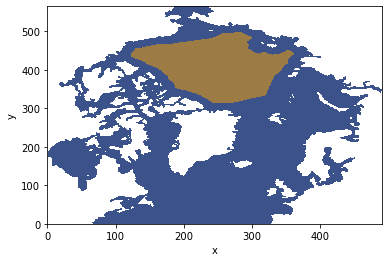

In [4]:
#Loading the mask files

dat_masks=xr.open_dataset(diri+"NANUK4.L31-I/mesh_mask_NANUK4_L31_4.2.nc") #global mask of the configuration
dat_masks_domain=xr.open_dataset("../Masks/masks_domain_threshold_0.5.nc") #mask of the domain of interest over which the CRPS is computed

##Visualisation of the global and domain tmasks

plt.contourf(dat_masks.tmask[0,0,:,:].where(dat_masks.tmask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.tmask.where(dat_masks_domain.tmask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

In [5]:
#Defining the variables of interest
##The structure of the list is the following:
##var_interest=["variable NEMO name","point NEMO grid","units","long name"]

var_interest=[["siconc","T","","sea ice concentration"],\
              ["sithic","T","m","sea ice thickness"],\
              ["u_ice-u","U","m/s","X-component of sea ice velocity @U"],\
              ["v_ice-v","V","m/s","Y-component of sea ice velocity @V"],\
              ["sidefo-t","T","s-1","deformation rate of sea ice velocity @T"]]

print(var_interest)

[['siconc', 'T', '', 'sea ice concentration'], ['sithic', 'T', 'm', 'sea ice thickness'], ['u_ice-u', 'U', 'm/s', 'X-component of sea ice velocity @U'], ['v_ice-v', 'V', 'm/s', 'Y-component of sea ice velocity @V'], ['sidefo-t', 'T', 's-1', 'deformation rate of sea ice velocity @T']]


In [6]:
#Saving the sizes of interest and the time as an array (same sizes for all the members)

size_t=dat[0][var_interest[0][0]].sizes["time_counter"]
size_x=dat[0][var_interest[0][0]].sizes["x"]
size_y=dat[0][var_interest[0][0]].sizes["y"]
print("t",size_t,"x",size_x,"y",size_y)

time=dat[0].time_counter.values
print(time,len(time))

t 240 x 492 y 566
['1997-03-27T00:30:00.000000000' '1997-03-27T01:30:00.000000000'
 '1997-03-27T02:30:00.000000000' '1997-03-27T03:30:00.000000000'
 '1997-03-27T04:30:00.000000000' '1997-03-27T05:30:00.000000000'
 '1997-03-27T06:30:00.000000000' '1997-03-27T07:30:00.000000000'
 '1997-03-27T08:30:00.000000000' '1997-03-27T09:30:00.000000000'
 '1997-03-27T10:30:00.000000000' '1997-03-27T11:30:00.000000000'
 '1997-03-27T12:30:00.000000000' '1997-03-27T13:30:00.000000000'
 '1997-03-27T14:30:00.000000000' '1997-03-27T15:30:00.000000000'
 '1997-03-27T16:30:00.000000000' '1997-03-27T17:30:00.000000000'
 '1997-03-27T18:30:00.000000000' '1997-03-27T19:30:00.000000000'
 '1997-03-27T20:30:00.000000000' '1997-03-27T21:30:00.000000000'
 '1997-03-27T22:30:00.000000000' '1997-03-27T23:30:00.000000000'
 '1997-03-28T00:30:00.000000000' '1997-03-28T01:30:00.000000000'
 '1997-03-28T02:30:00.000000000' '1997-03-28T03:30:00.000000000'
 '1997-03-28T04:30:00.000000000' '1997-03-28T05:30:00.000000000'
 '1997-

### Data preparation

In this part we put the data into a compatible format for the function: edam.scores.crps. To do that, for each member, variable of interest and time step, we transform the corresponding (size_y,size_x) array into a 1D array of size size_y*size_x. Then, we keep only the values corresponding to unmasked values (according to the chosen mask).

In [7]:
#Choosing the mask of interest, transforming it into a 1D array and stocking the index of the unmasked cells

flat_mask=[] #initilisation of the list that will contain for each variable the mask of interest as a 1D array
pos_mask=[] #initilisation of the list that will contain for each variable the positions of the unmasked values

for ivar in range(len(var_interest)): #iteration over the variables of interest
    var=var_interest[ivar][0]
    mask=libensdiv.maskpt(dat_masks,dat_masks_domain,var_interest[ivar][1])[0] #mask of interest according to the variable of interest
    #print(var,mask)
    #print("size y",size_y,"size x",size_x,np.shape(mask))
    flat_mask.append(mask.astype(np.float64).values.flatten()) #transform the 2D mask into a 1D mask
    pos_mask.append(np.where(flat_mask[ivar]>0.)[0]) #positions of where the mask is equal to 1
print("number of variable:",len(flat_mask))

number of variable: 5


In [8]:
#Transforming 2D arrays into 1D arrays for each member, variable of interest and time step
##At the end we keep only the values of the unmasked cells

dat_flatyx=[] #initialisation of the list that will contain for each variable a DataArray storing the 1D arrays

for ivar in range(len(var_interest)): #iteration over the variables

    var=var_interest[ivar][0] ; print(var)

    #initialisation of a DataArray that will contain the 1D arrays
    dat_flatyx_tmp=xr.DataArray(data=np.zeros((size_t,nb_member,len(pos_mask[ivar])),dtype="float64")+999.999,\
                         dims=["time","member_ref","flatyx"])
    print("number of unmasked values: ",len(pos_mask[ivar]),np.shape(dat_flatyx_tmp),dat_flatyx_tmp.dtype)
    
    for t in range(size_t): #iteration over time
        for imb in range(nb_member): #iteration over the members
            
            flatyx_tmp=dat[imb][var][t,:,:].astype(np.float64).values.flatten() #transformation of 2D arrays into 1D arrays
            dat_flatyx_tmp[t,imb,:]=flatyx_tmp[pos_mask[ivar]] #keeping only the unmasked values
        
    dat_flatyx.append(dat_flatyx_tmp)
print(len(dat_flatyx))

siconc
number of unmasked values:  25148 (240, 20, 25148) float64
sithic
number of unmasked values:  25148 (240, 20, 25148) float64
u_ice-u
number of unmasked values:  25350 (240, 20, 25350) float64
v_ice-v
number of unmasked values:  25399 (240, 20, 25399) float64
sidefo-t
number of unmasked values:  25148 (240, 20, 25148) float64
5


### Computing the CRPS

In [9]:
#Computing the CRPS and its components

##Initialisation of the variables that will store the computed CRPS and components
CRPS=np.zeros((len(var_interest),size_t,nb_member),dtype="float64")+1.e20
CRPS_reli=np.zeros((len(var_interest),size_t,nb_member),dtype="float64")+1.e20
CRPS_reso=np.zeros((len(var_interest),size_t,nb_member),dtype="float64")+1.e20

for ivar in range(len(var_interest)): #iteration over the variables of interest 
    var=var_interest[ivar][0] ; print(var)
    
	##Computing the CRPS
    for t in range(size_t): #iteration over time
    	for n in list_member: #iteration over the members => one member taken as reference one after another
            
            reference=dat_flatyx[ivar].isel(dict(time=t,member_ref=n)).values #member of reference
            ensemble= dat_flatyx[ivar].isel(dict(time=t,member_ref=np.where(list_member!=n)[0])).values #other ensemble members
            
            CRPS[ivar,t,n],CRPS_reli[ivar,t,n],CRPS_reso[ivar,t,n] = edam.scores.crps(ensemble,reference) #computing the CRPS

siconc
sithic
u_ice-u
v_ice-v
sidefo-t


### Saving the CRPS and its components into NetCDF files

In [10]:
#path to the outputs directory
#path_results="/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/"+exp+"/"+period_interest+"/CRPS/"
path_results=""

In [11]:
#Saving the total CRPS

ds_crps = xr.Dataset(
    {
    var_interest[0][0]:    (["time", "member_ref"], CRPS[0,:,:]),
    var_interest[1][0]:    (["time", "member_ref"], CRPS[1,:,:]),
    var_interest[2][0]:    (["time", "member_ref"], CRPS[2,:,:]),
    var_interest[3][0]:    (["time", "member_ref"], CRPS[3,:,:]),
    var_interest[4][0]:    (["time", "member_ref"], CRPS[4,:,:])
    },
    coords={
    "time": time,
    "member_ref": list_member
    },
)

# attributes/encoding for coordinate time:
ds_crps.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
ds_crps.time.encoding['_FillValue'] = None
ds_crps.time.attrs['standard_name'] = 'time'

for ivar in range(len(var_interest)):
    vartot=var_interest[ivar]
    ds_crps[vartot[0]].attrs['_FillValue'] = 1.e20
    ds_crps[vartot[0]].attrs['units'] = vartot[2]
    ds_crps[vartot[0]].attrs['long_name'] = 'CRPS of '+vartot[3]

# global attribute:
ds_crps.attrs['history'] = 'Created using script 04-02-2025_CRPS_computation.py that used pyensdam.scores.crps function'

# write the file with UNLIMITED time:
ds_crps.to_netcdf(path_results+"CRPS_"+exp+"_"+period_interest+".nc",unlimited_dims="time")

In [12]:
#Saving the reliability component of the CRPS

ds_crps_reli = xr.Dataset(
    {
    var_interest[0][0]:    (["time", "member_ref"], CRPS_reli[0,:,:]),
    var_interest[1][0]:    (["time", "member_ref"], CRPS_reli[1,:,:]),
    var_interest[2][0]:    (["time", "member_ref"], CRPS_reli[2,:,:]),
    var_interest[3][0]:    (["time", "member_ref"], CRPS_reli[3,:,:]),
    var_interest[4][0]:    (["time", "member_ref"], CRPS_reli[4,:,:])
    },
    coords={
    "time": time,
    "member_ref": list_member
    },
)

# attributes/encoding for coordinate time:
ds_crps_reli.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
ds_crps_reli.time.encoding['_FillValue'] = None
ds_crps_reli.time.attrs['standard_name'] = 'time'

for ivar in range(len(var_interest)):
    vartot=var_interest[ivar]
    ds_crps_reli[vartot[0]].attrs['_FillValue'] = 1.e20
    ds_crps_reli[vartot[0]].attrs['units'] = vartot[2]
    ds_crps_reli[vartot[0]].attrs['long_name'] = 'CRPS reliability component of '+vartot[3]

# global attribute:
ds_crps_reli.attrs['history'] = 'Created using script 04-02-2025_CRPS_computation.py that used pyensdam.scores.crps function'

# write the file with UNLIMITED time:
ds_crps_reli.to_netcdf(path_results+"CRPS_reli_"+exp+"_"+period_interest+".nc",unlimited_dims="time")

In [13]:
#Saving the resolution component of the CRPS

ds_crps_reso = xr.Dataset(
    {
    var_interest[0][0]:    (["time", "member_ref"], CRPS_reso[0,:,:]),
    var_interest[1][0]:    (["time", "member_ref"], CRPS_reso[1,:,:]),
    var_interest[2][0]:    (["time", "member_ref"], CRPS_reso[2,:,:]),
    var_interest[3][0]:    (["time", "member_ref"], CRPS_reso[3,:,:]),
    var_interest[4][0]:    (["time", "member_ref"], CRPS_reso[4,:,:])
    },
    coords={
    "time": time,
    "member_ref": list_member
    },
)

# attributes/encoding for coordinate time:
ds_crps_reso.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
ds_crps_reso.time.encoding['_FillValue'] = None
ds_crps_reso.time.attrs['standard_name'] = 'time'

for ivar in range(len(var_interest)):
    vartot=var_interest[ivar]
    ds_crps_reso[vartot[0]].attrs['_FillValue'] = 1.e20
    ds_crps_reso[vartot[0]].attrs['units'] = vartot[2]
    ds_crps_reso[vartot[0]].attrs['long_name'] = 'CRPS resolution component of '+vartot[3]

# global attribute:
ds_crps_reso.attrs['history'] = 'Created using script 04-02-2025_CRPS_computation.py that used pyensdam.scores.crps function'

# write the file with UNLIMITED time:
ds_crps_reso.to_netcdf(path_results+"CRPS_reso_"+exp+"_"+period_interest+".nc",unlimited_dims="time")